In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

### Define gridworld

In [10]:
# Define mappings
state_to_idx = {(i, j): i * 3 + j for i in range(3) for j in range(3)}
idx_to_state = {v: k for k, v in state_to_idx.items()}
actions = ['up', 'down', 'left', 'right']
action_to_idx = {a: i for i, a in enumerate(actions)}

# One-hot encodings
def one_hot(index, size):
    vec = torch.zeros(size)
    vec[index] = 1.0
    return vec

# Environment simulator
class SimpleGridWorld3x3:
    def __init__(self):
        self.grid_size = (3, 3)
        self.actions = actions

    def step(self, state, action):
        x, y = state
        if action == 'up':
            x = max(0, x - 1)
        elif action == 'down':
            x = min(self.grid_size[0] - 1, x + 1)
        elif action == 'left':
            y = max(0, y - 1)
        elif action == 'right':
            y = min(self.grid_size[1] - 1, y + 1)
        return (x, y)

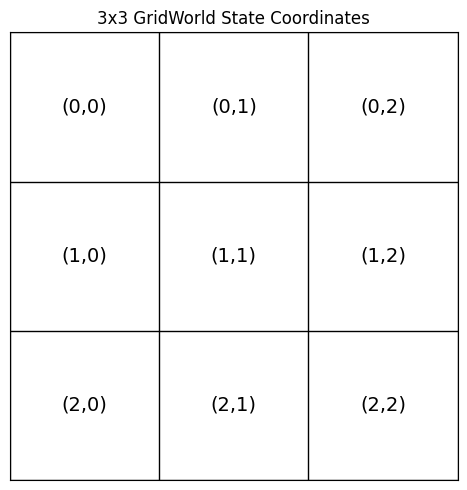

In [8]:
def plot_gridworld_3x3():
    fig, ax = plt.subplots(figsize=(5, 5))

    # Draw grid lines for a 3x3 grid
    for x in range(4):  # 3 cells => 4 lines
        ax.plot([0, 3], [x, x], 'k-', lw=1)
        ax.plot([x, x], [0, 3], 'k-', lw=1)

    # Place coordinate labels
    for i in range(3):
        for j in range(3):
            ax.text(j + 0.5, 2.5 - i, f"({i},{j})", ha='center', va='center', fontsize=14)

    # Formatting
    ax.set_xlim(0, 3)
    ax.set_ylim(0, 3)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    ax.set_title("3x3 GridWorld State Coordinates")
    plt.tight_layout()
    plt.show()

plot_gridworld_3x3()

### Implementing an RNN on it

In [14]:
# Modified RNN model
class GridRNN(nn.Module):
    def __init__(self, input_size=13, hidden_size=16, output_size=9):  # 9 states + 4 actions = 13 input, 9 output
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, h=None):
        out, h = self.rnn(x, h)
        logits = self.fc(out)
        return logits, h

# Training loop
def train_rnn(env, model, optimizer, criterion, epochs=1000):
    for epoch in range(epochs):
        state = random.choice(list(state_to_idx.keys()))
        action = random.choice(actions)
        next_state = env.step(state, action)

        # Prepare input and target
        state_vec = one_hot(state_to_idx[state], 9)
        action_vec = one_hot(action_to_idx[action], 4)
        input_vec = torch.cat([state_vec, action_vec]).unsqueeze(0).unsqueeze(0)  # (1, 1, 13)
        target = torch.tensor([[state_to_idx[next_state]]])  # (1, 1)

        # Forward pass
        logits, _ = model(input_vec)
        loss = criterion(logits.squeeze(0), target.squeeze(0))

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 200 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Initialize everything
env = SimpleGridWorld3x3()
model = GridRNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Train the model
train_rnn(env, model, optimizer, criterion)

Epoch 0, Loss: 2.8355
Epoch 200, Loss: 0.9297
Epoch 400, Loss: 0.3171
Epoch 600, Loss: 0.1941
Epoch 800, Loss: 0.0959


### Extract hidden representations

/Users/neur1s/miniconda3/.conda/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


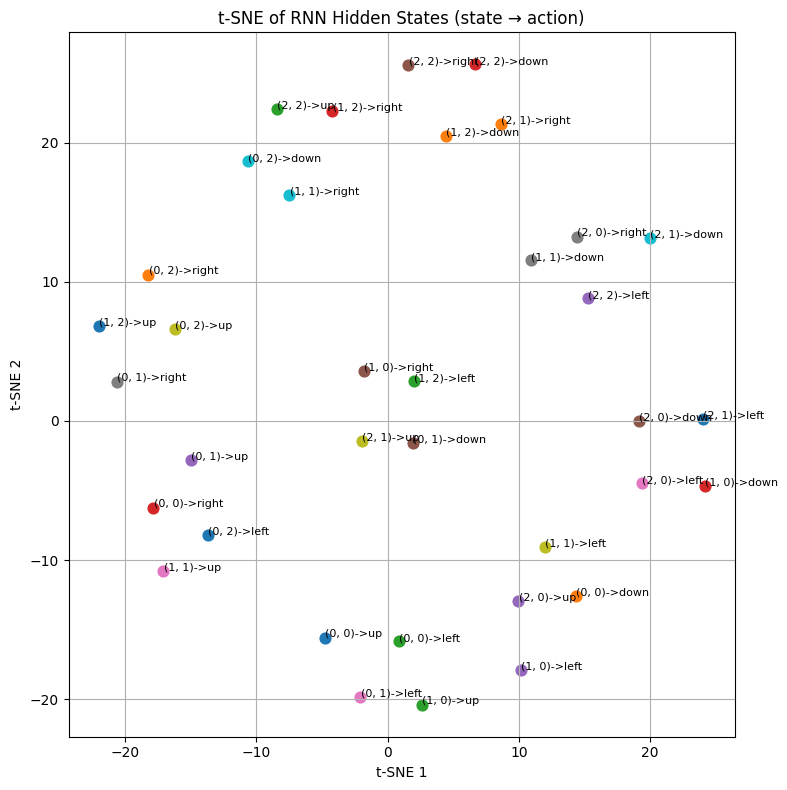

In [15]:
hidden_states = []
labels = []

with torch.no_grad():
    for s in state_to_idx:
        for a in actions:
            s_vec = one_hot(state_to_idx[s], 9)  # 9 states now
            a_vec = one_hot(action_to_idx[a], 4)
            x = torch.cat([s_vec, a_vec]).unsqueeze(0).unsqueeze(0)  # (1, 1, 13)
            _, h = model(x)
            hidden_states.append(h.squeeze(0).squeeze(0).numpy())  # (hidden_size,)
            labels.append(f"{s}->{a}")

# t-SNE visualization
hidden_states_np = np.array(hidden_states)

tsne = TSNE(n_components=2, perplexity=10, random_state=42)
z = tsne.fit_transform(hidden_states_np)

plt.figure(figsize=(8, 8))
for i, label in enumerate(labels):
    plt.scatter(z[i, 0], z[i, 1], s=60)
    plt.text(z[i, 0] + 0.02, z[i, 1] + 0.02, label, fontsize=8)
plt.title("t-SNE of RNN Hidden States (state → action)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()
plt.show()